In [1]:
# I'm just going to optimize with numerical gradients
import numpy as np
import scipy.optimize as opt
import scipy.ndimage

# for viewing
import matplotlib.pyplot as plt

# for warping
import skimage.io
from skimage.transform import rescale, warp, AffineTransform,EuclideanTransform
from skimage import filters, feature
from skimage.measure import ransac

In [2]:
# load image, turn into [0,1] and shrink the giant one
template_orig = rescale(skimage.io.imread('cmu2.jpg').astype(np.float32)/255,0.5)
source_orig = rescale(skimage.io.imread('cmu1.jpg').astype(np.float32)/255,0.1)


source_orig.shape,template_orig.shape

/Users/lkeselma/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/lkeselma/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/lkeselma/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


((409, 614, 3), (110, 124, 3))

In [3]:
def turn_into_edges(im):
    return np.stack([scipy.ndimage.sobel(im[:,:,i]) for i in range(3)],axis=-1)/4
source = turn_into_edges(source_orig).astype(np.float32)
template = turn_into_edges(template_orig).astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


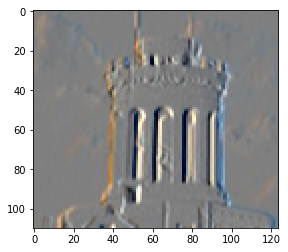

In [4]:
plt.imshow(template + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


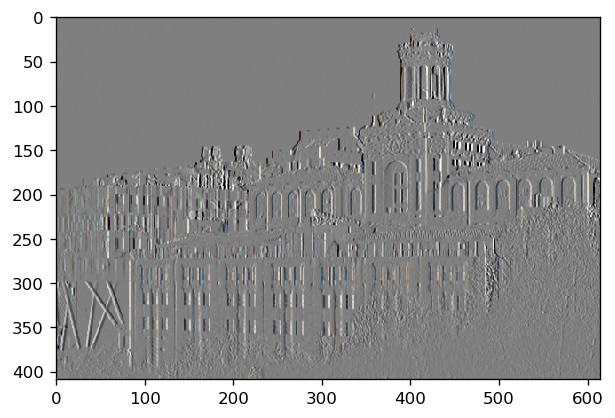

In [5]:
plt.figure(dpi=120)
plt.imshow(source + 0.5)

In [6]:
import cv2
res = cv2.matchTemplate(source[:,:,1].astype(np.float32), template[:,:,1].astype(np.float32), cv2.TM_CCOEFF)
_, max_val, _, max_loc = cv2.minMaxLoc(res)
# initial guess from correlation
max_loc

(349, 6)

In [7]:
# add noise
np.random.seed(42)
max_loc_n = max_loc + np.random.randn(2)*5

In [8]:
# try to normalize parameters to be roughly the same scale (order of 100)
T = np.array(max_loc_n) # x, y in pixels
angle = 5 # in degrees
scale = 100 # as a percentage, 200 =  half size

intial_v = np.array(list(T) + [angle,scale])

out_size = source.shape

In [9]:
# form a homogenous transform matrix from params
c, s = scale*np.cos(np.pi*angle/180)/100, scale*np.sin(np.pi*angle/180)/100
A = np.array([[c, s, -T[0]*(scale/100)], [-s, c, -T[1]*(scale/100)], [0,0,1]])

In [10]:
A

array([[ 9.96194698e-01,  8.71557427e-02, -3.51483571e+02],
       [-8.71557427e-02,  9.96194698e-01, -5.30867849e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

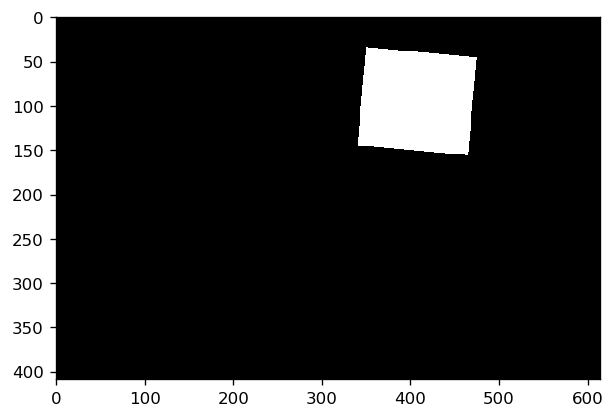

In [11]:
plt.figure(dpi=120)
plt.imshow(warp(np.ones_like(template),A,output_shape=out_size))

In [12]:
# compute error
def compute_err(x):
    T = x[:2]
    angle = np.pi*x[2]/180.0
    scale = x[3]/100
    c, s = scale*np.cos(angle), scale*np.sin(angle)
    A = np.array([[c, s, -scale*T[0]], [-s, c, -scale*T[1]], [0,0,1]])
    Wres = warp(template,A,output_shape=out_size)- source
    Mask = warp(np.ones_like(template),A,output_shape=out_size)
    # use mean squared error
    err = 100*((Wres*Mask)**2).sum()/Mask.sum()
    
    # if we've warped off image coordinates, throw it out
    # 10 is a lot in image gradient with images 0 to 1
    if Mask.sum() < 3*template.shape[0]*template.shape[1]*(1/scale)*(1/scale)*0.9:
        return 10
    #print(err)
    #print(x)
    return err
print(compute_err(intial_v))


1.9372477778900734


In [13]:
# could use this
#res = opt.minimize(compute_err,intial_v, method='CG',options={'eps':1,'maxiter': 20, 'disp': True, 'return_all': False})
#resx = res.x

In [14]:
# this is must faster/better
import cma
# we can use a sigma of 1, which corresponds to 1 pixel, 1 degree, 1% change in scale, etc
# b/c I resized the parameter space
es = cma.CMAEvolutionStrategy(intial_v,1)
res = es.optimize(compute_err,iterations=15)
resx = es.result_pretty().xbest

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=379853, Fri Dec 13 17:36:07 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.868940379698032e+00 1.0e+00 9.36e-01  9e-01  1e+00 0:02.5
    2     16 1.645532085937772e+00 1.3e+00 1.10e+00  1e+00  1e+00 0:03.9
    3     24 1.502657381966893e+00 1.6e+00 1.38e+00  1e+00  2e+00 0:05.0
    6     48 1.405214480375003e+00 2.2e+00 1.97e+00  2e+00  3e+00 0:09.0
    8     64 1.266411076805599e+00 1.7e+00 1.77e+00  2e+00  2e+00 0:13.8
   12     96 1.138260991249647e+00 2.1e+00 1.58e+00  1e+00  2e+00 0:19.7
final/bestever f-value = 1.245353e+00 1.138261e+00
incumbent solution: [346.3686390107055, 0.2459645795423714, -0.4263722991516742, 95.77431493915347]
std deviation: [0.8426628197957566, 1.6808624037254796, 0.9210562613469876, 0.8453522794412099]


In [15]:
resx[:2]

array([347.09091256,   2.88917691])

In [16]:
resx[2]

0.017154883385114728

In [17]:
resx[3]

96.59327150886783

Text(0.5, 1.0, 'initial')

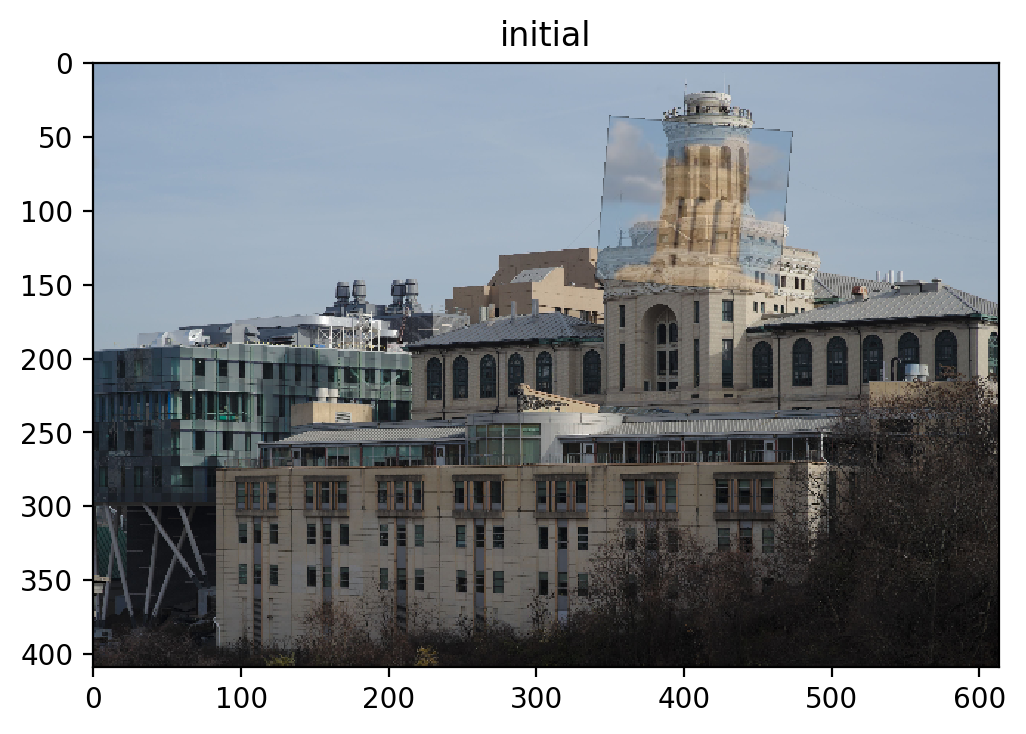

In [18]:
x = intial_v
T = x[:2]
angle = np.pi*x[2]/180.0
scale = x[3]/100
c, s = scale*np.cos(angle), scale*np.sin(angle)
A = np.array([[c, s, -scale*T[0]], [-s, c, -scale*T[1]], [0,0,1]])
Wres = warp(template,A,output_shape=out_size)- source
Mask = warp(np.ones_like(template),A,output_shape=out_size)

plt.figure(dpi=200)
plt.imshow(source_orig*(1-0.5*Mask) + 0.5*warp(template_orig,A,output_shape=out_size))
plt.title('initial')

Text(0.5, 1.0, 'final')

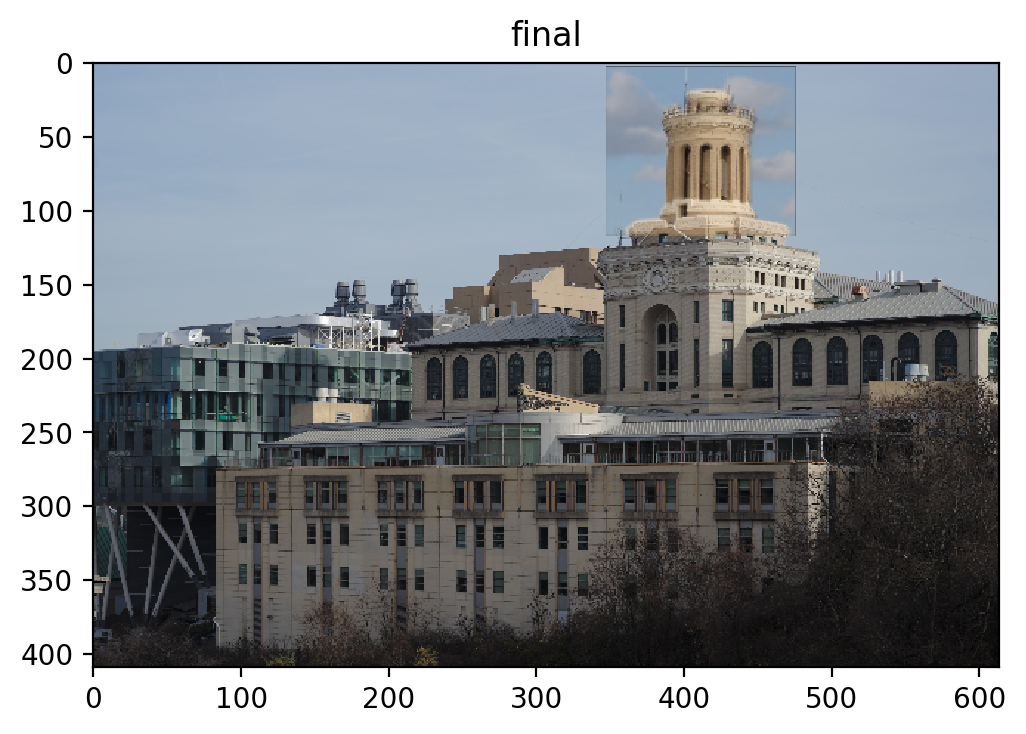

In [19]:
x = resx
T = x[:2]
angle = np.pi*x[2]/180.0
scale = x[3]/100
c, s = scale*np.cos(angle), scale*np.sin(angle)
A = np.array([[c, s, -scale*T[0]], [-s, c, -scale*T[1]], [0,0,1]])
Wres = warp(template,A,output_shape=out_size)- source
Mask = warp(np.ones_like(template),A,output_shape=out_size)

plt.figure(dpi=200)
plt.imshow(source_orig*(1-0.5*Mask) + 0.5*warp(template_orig,A,output_shape=out_size))
plt.title('final')

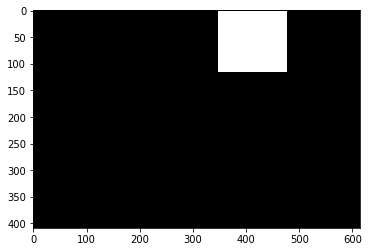

In [20]:
plt.imshow(Mask)

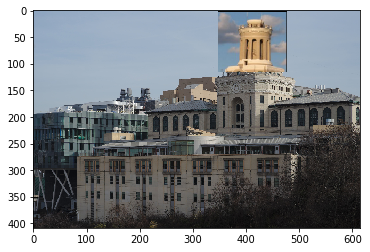

In [21]:
plt.imshow(source_orig*(1-Mask) + warp(template_orig,A,output_shape=out_size))
